In [1]:
import os
from torchvision import datasets,transforms
import torch.nn as nn
import torch
import torchvision.utils as vutils

C:\Users\zelon\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [3]:
batch_size=64
learning_rate=0.0002
epochs=100
z=100  #size of latent vector
in_channels=3 #Number of color channels
ec=1
path_to_progress_img="./Wprogress/" 
path_to_weights="./Wweights/"
path_to_images="./img/"
clip_val=.01
n_crit=5 

In [4]:
import numpy
data=datasets.ImageFolder(
    path_to_images,
    transform=transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5)),
    ]))

In [5]:
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size,
                                         shuffle=True)

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.convT = nn.Sequential(
        nn.ConvTranspose2d(in_channels=z,out_channels=ec*512,kernel_size=4,stride=1,padding=0),
        nn.BatchNorm2d(ec*512),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(in_channels=ec*512,out_channels=ec*256,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(ec*256),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(in_channels=ec*256,out_channels=ec*128,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(ec*128),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(in_channels=ec*128,out_channels=ec*64,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(ec*64),
        nn.LeakyReLU(0.2),
        nn.ConvTranspose2d(in_channels=ec*64,out_channels=in_channels,kernel_size=4,stride=2,padding=1),
        nn.Tanh(),
        )
    def forward(self, x):
        x=self.convT(x)
        return x

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=64,kernel_size=4,stride=2,padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=512,out_channels=1,kernel_size=4,stride=2,padding=0),
        )
    def forward(self, x):
        x=self.conv(x)
        return x

In [8]:
gen=Generator().to(device)
dis=Discriminator().to(device)

In [9]:
lossFun=nn.BCEWithLogitsLoss()
fixed_noise = torch.randn(batch_size, z, 1, 1,device=device)
real_label = 1
fake_label = 0

In [10]:
optimizerD = torch.optim.Adam(dis.parameters(), lr=learning_rate,betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(gen.parameters(), lr=learning_rate,betas=(0.5, 0.999))

In [11]:
def smooth_positive_labels(y):
 return y - 0.3 + (torch.rand(y.shape,device=device) * 0.5)
def smooth_negative_labels(y):
 return y + torch.rand(y.shape,device=device) * 0.3

In [12]:
def initialize_fn(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
if (len(os.listdir(path_to_weights)) == 0):
        dis.apply(initialize_fn)
        gen.apply(initialize_fn)
else:
        idx=len(os.listdir(path_to_weights))//2
        dis.load_state_dict(torch.load(path_to_weights+"dis_epoch_%d.pth" % idx))
        gen.load_state_dict(torch.load(path_to_weights+"gen_epoch_%d.pth" % idx))

In [ ]:
for epoch in range(epochs):
        for i, data in enumerate(dataloader,0):
                optimizerD.zero_grad()
                real=data[0].to(device)
                batch_size=real.size(0)
                noise = torch.randn(batch_size, z, 1, 1, device=device)
                fake = gen(noise).detach()

                D_x = torch.mean(dis(real))
                D_G_z1 = torch.mean(dis(fake))
                
                dis_loss= D_G_z1 -  D_x

                dis_loss.backward()
                optimizerD.step()

                for params in dis.parameters():
                        params.data.clamp_(-clip_val,clip_val)

                if i % n_crit == 0:
                        optimizerG.zero_grad()
                        crit_fake=gen(noise)
                        gen_loss= - torch.mean(dis(crit_fake))
                        gen_loss.backward()
                        optimizerG.step()


                print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f'
                % (epoch, epochs, i, len(dataloader),
                        dis_loss.item(), gen_loss.item(), D_x, D_G_z1))
                if i % 50 == 0:
                        vutils.save_image(real,
                                '%s/real_samples.png' % path_to_progress_img,
                                normalize=True)
                        fake = gen(fixed_noise)
                        vutils.save_image(fake.detach(),
                                '%s/fake_samples_epoch_%03d.png' % (path_to_progress_img, epoch),
                                normalize=True)
        torch.save(gen.state_dict(), '%s/gen_epoch_%d.pth' % (path_to_weights, epoch))
        torch.save(dis.state_dict(), '%s/dis_epoch_%d.pth' % (path_to_weights, epoch))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


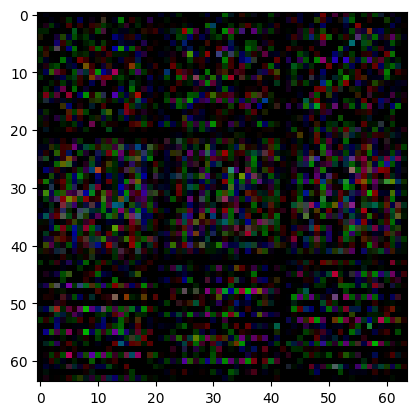

In [15]:
import matplotlib.pyplot as plt
plt.imshow(gen(torch.randn(1, z, 1, 1, device=device)).detach().reshape([64,64,in_channels]))